# Modelo para detectar las críticas negativas de películas clásicas para la comunidad Film Junky Union

**Tabla de contenidos**

* [Descripción del proyecto](#intro) 
* [Inicializacion](#initialization)
* [Cargar datos](#data_loading)
* [Análsis Exploratorio de Datos](#eda)
* [Procedimiento de evaluación](#evaluation)
* [Normalización](#normalization)
* [División entrenamiento / prueba](#tranning_test_sets)
* [Trabajar con modelos](#modelling)
* [Mis reseñas](#reviews)
* [Conclusiones](#conclusions)

# Descripción del proyecto <a name="intro"></a>

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

# Inicialización <a name="initialization"></a>

In [71]:
import math

import numpy as np
import pandas as pd
import re
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='feature_fraction is set')

In [72]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [73]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

# Cargar datos <a name="data_loading"></a>

In [74]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [75]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [76]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [77]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [78]:
df_reviews.duplicated().sum()

0

In [79]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [80]:
df_reviews['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

**Conclusiones intermedias**

1. La conclusión más importante es que los valores del objetivo ("pos") se encuentran balanceados. Es decir, existe un número similar de reseñas positvas y negativas.
2. Los datos de reseñas y del objetivo ("pos") no presentan valores ausentes, y tienen tipos de datos coherentes para el análisis ("object" e "int" resepctivamente").


# Análisis exploratorio de datos <a name="eda"></a> 

Veamos el número de películas y reseñas a lo largo de los años.

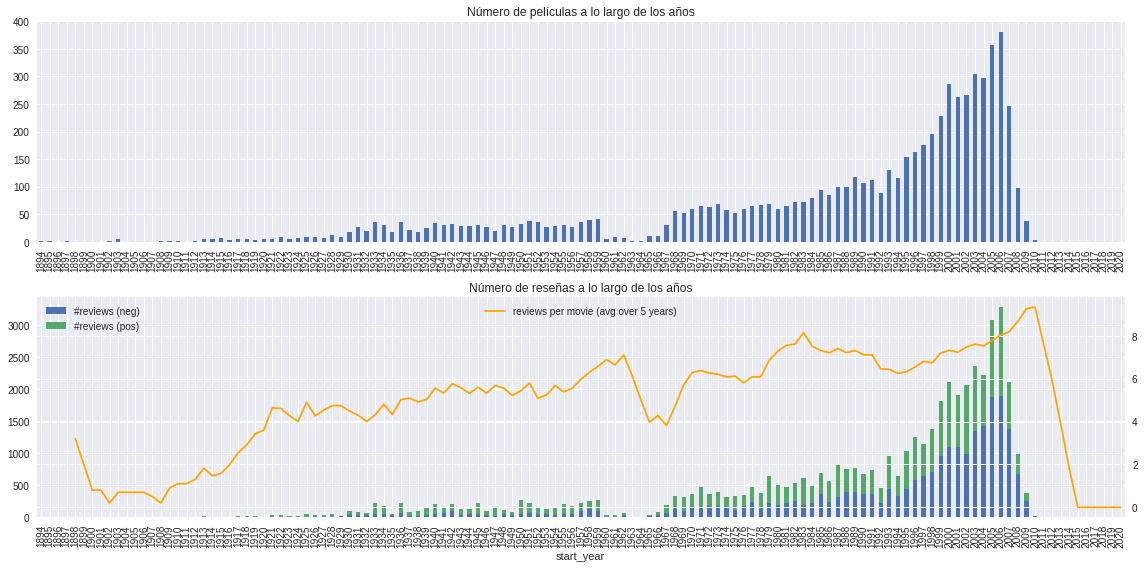

In [81]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

labels_stacked = ['#reviews (neg)', '#reviews (pos)']
dft2.plot(kind='bar', stacked=True, ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, labels_stacked, loc='upper left')

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
axt.legend(lines, labels, loc='upper center')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

1. Se apreacia un incremento en el número de películas y de reseñas en el tiempo. En el año 2006 se alcanza un pico de 450 películas. En este mismo año, también se alcanza el máximo de número de reseñas sobrepasando las 3000. 

2. Las reseñas positvas y negativas se encuentran relativamente equilibradas a lo largo del tiempo. 

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

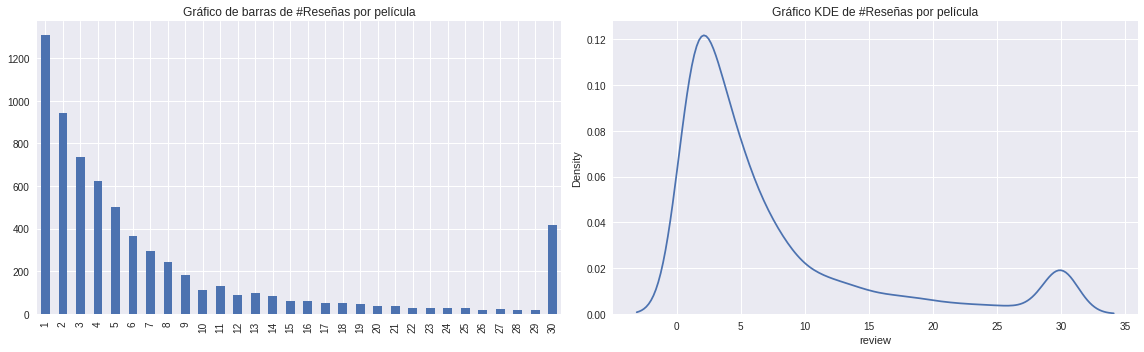

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

1. Existen películas que recibieron hasta 1200 reseñas, aunque la mayoría ha recibido al menos una.

In [83]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

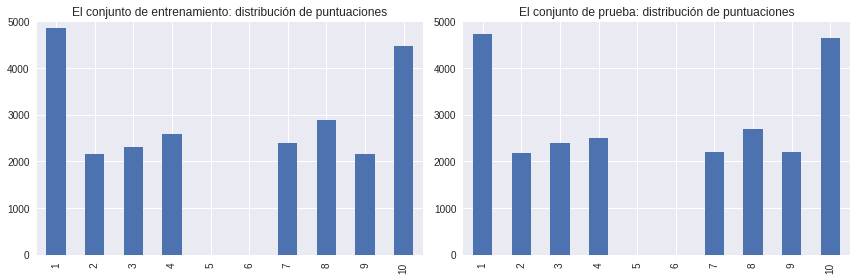

In [84]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

1. La distribución de datos de valoración de películas se encuentran equilibradas entre los conjuntos de entrenamiento y prueba. En ambos conjuntos no existen datos para valoraciones de 5 y 6.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


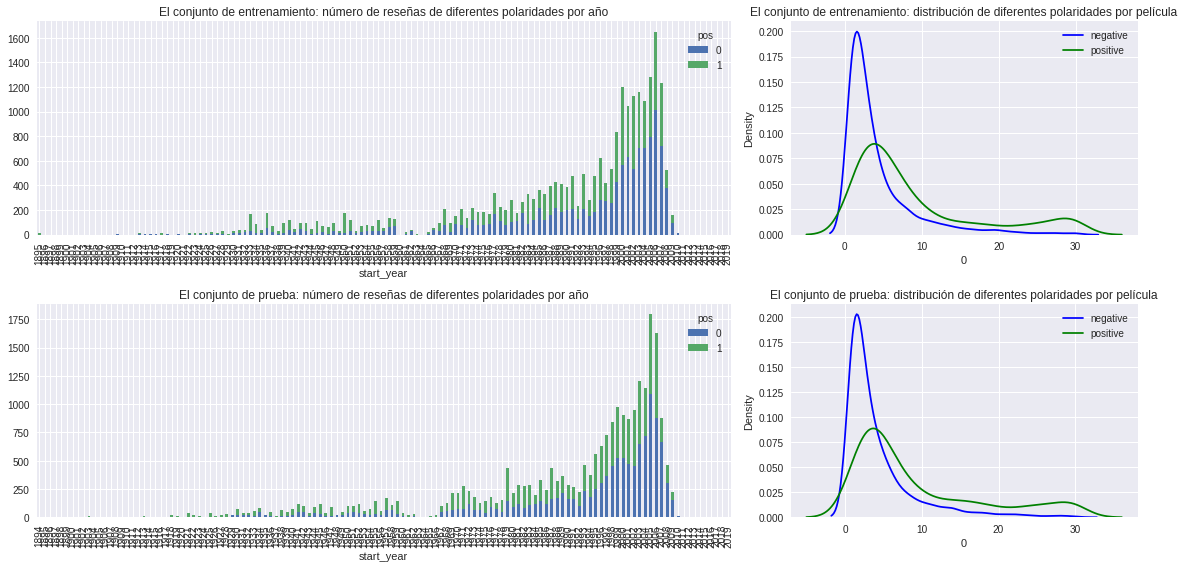

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

1. Las valoraciones de reseñas positivas y negativas se encuentran equilibradas a lo largo del tiempo para los conjuntos de entrenamiento y prueba.

**Conclusiones intermedias**

1. El análisis exploratorio de datos confirma que las reseñas positivas y negativas se encuentran balanceadas.
2. La conclusión anterior es válida también cuando se analizan por separado los conjuntos de entrenamiento y prueba.
3. Como se podría esperar, el número de películas y reseñas aumenta en el tiempo.  

# Procedimiento de evaluación <a name="evaluation"></a>

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [86]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalización <a name="normalization"></a>

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [87]:
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47331, dtype: object

In [88]:
# Función para limpieza de texto

def clean_text(text):
    
    """
    La función toma un texto y realiza una limpieza
    usnado expresiones regualres para que el mismo 
    este listo para un análisis de sentimiento 
    """
    
    # Convierte el texto a minúsculas
    text = text.lower()
    
    # Remueve números
    text = re.sub(r'\d+', '', text)
    
    # Remueve signos de puntuación y caractéres especiales
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remueve espacios en blanco extras
    text = re.sub(r'\s+', ' ', text)
    
    return text


In [89]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

In [90]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        im totally agree with garryjohal from singapor...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_norm, Length: 47331, dtype: object

# División entrenamiento / prueba <a name="tranning_test_sets"></a>

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [91]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


# Trabajar con modelos <a name="modelling"></a>

**Modelo 0 - Constante**

In [92]:
# Modelo Dummy
dummy_model = DummyClassifier()
dummy_model.fit(df_reviews_train['review_norm'], train_target)
preds = dummy_model.predict(df_reviews_train['review_norm'])
score_dummy = f1_score(train_target, preds)
print("F1 score", score_dummy)

F1 score 0.0


          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


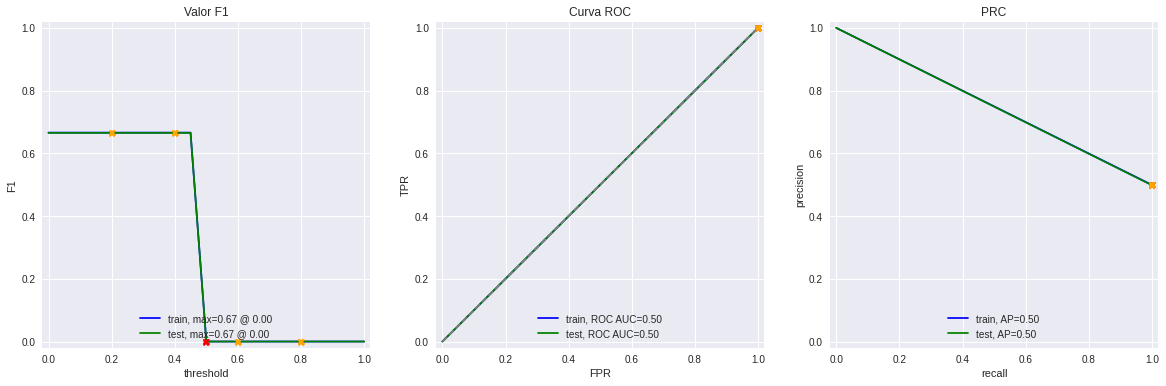

In [93]:
evaluate_model(dummy_model, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)

1. El modelo "dummy" no tiene ninguna capacidad de predicción.

**Modelo 1 - NLTK, TF-IDF y LR**

TF-IDF

In [94]:
lemmatizer  = WordNetLemmatizer()

In [95]:
# Función para la tokenización y lematización de textos
# usando la librería NLTK

def text_preprocessing_nltk(text):
    """
    Función para la tonenización y lematización de textos
    """
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)

In [96]:
# Aplica la función de procesamitno de texto (tokenización y lematización) 
# a los datos de reseñas normalizados (conjuntos de prueba y entrenamiento) 

df_reviews_train['review_nltk'] = df_reviews_train['review_norm'].apply(text_preprocessing_nltk)
df_reviews_test['review_nltk'] = df_reviews_test['review_norm'].apply(text_preprocessing_nltk)

In [97]:
# Vectoriza las reseñas aplicando el método TF-IDF

tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_nltk'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_nltk'])

In [98]:
# Modelo de regresión logística

lr = LogisticRegression()
lr.fit(train_features_1, train_target)
y_pred_1 = lr.predict(test_features_1)
score_lr = f1_score(test_target, y_pred_1)
print("F1:", score_lr)

F1: 0.879597664407791


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


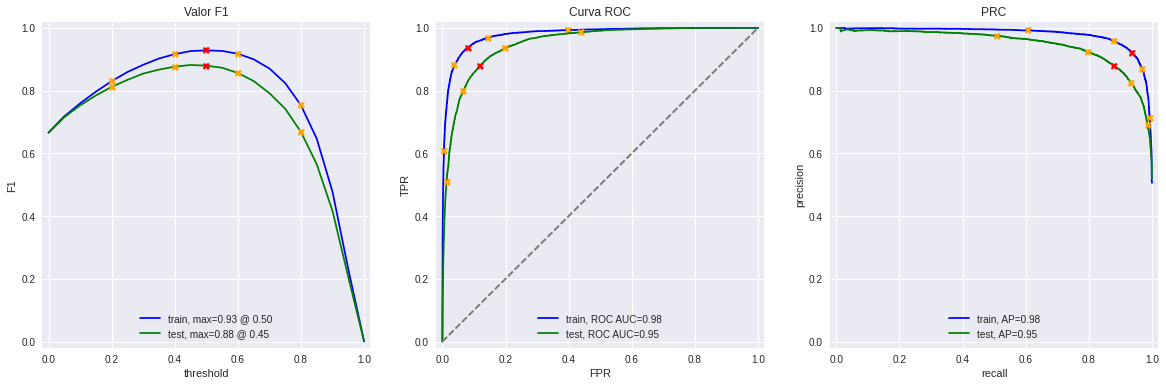

In [99]:
evaluate_model(lr, train_features_1, train_target, test_features_1, test_target)

1. No existen señales de sobreajuste del modelo. Incluso para los valores más altos  de F1 entre los conjuntos de entrenamiento y prueba, la diferencia entre los mismos es pequeña con un F1 de 0.93 para el conjunto de entrenamiento y 0.88 para los datos de prueba.  

**Modelo 3 - spaCy, TF-IDF y LR**

In [100]:
# Crea instancia de procesamiento natural de texto con la librería Spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [101]:
# Función para el preprocesamiento de texto con Spacy

def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [102]:
%%time
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

CPU times: user 16min 31s, sys: 675 ms, total: 16min 32s
Wall time: 16min 33s


In [103]:
# Crea conjuntos de entrenamiento y prueba con textos  
# tokenizados y lematizados usando la librería spacy

train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

In [104]:
# Modelo de regresión logística

lr.fit(train_features_3, train_target)
y_pred_3 = lr.predict(test_features_3)
score_lr_3 = f1_score(test_target, y_pred_3)
print("F1:", score_lr_3)

F1: 0.87906106480694


          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


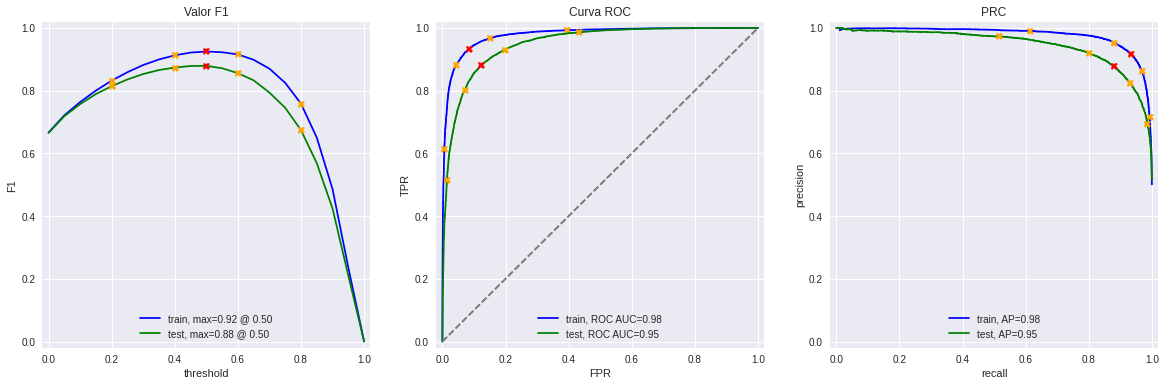

In [105]:
evaluate_model(lr, train_features_3, train_target, test_features_3, test_target)

1. De igual forma que para el modelo 1, este modelo no presenta señales de sobreajuste con un F1 en el conjunto de entrenamienteo de 0.92 y 0.88 para el conjunto de prueba. 

**Modelo 4 - spaCy, TF-IDF y LGBMClassifier**

In [107]:
# Modelo LGBMClassifier

# Creación de instancia del modelo
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type='gbdt',
                      objective='binary',
                      feature_fraction=0.8,
                      random_state=42,
                      verbosity=-1)

# Creación de parámentros para ajuste del modelo
#param = {'n_estimators': range(50, 300, 50)}
param = {}

# Definición de parámetros para la validación cruzada
gs = GridSearchCV(lgbm, param_grid=param, cv=5, scoring='f1_weighted')

# Ajuste del modelo
lgbm_model =  gs.fit(train_features_3, train_target)

# Imprime los resutlados del mejor ajuste del modelo
print(lgbm_model.best_params_, lgbm_model.best_score_)

# Obtiene un diccionario con la información de los resultados
results = lgbm_model.cv_results_

# Obtiene el mejor índice
best_index = lgbm_model.best_index_

# Devuleve los resutlados
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]

print('Fit time:', fit_time)
print('Score time:', score_time)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
{} 0.8488978228279558
Fit time: 37.29070153236389
Score time: 0.05752229690551758


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


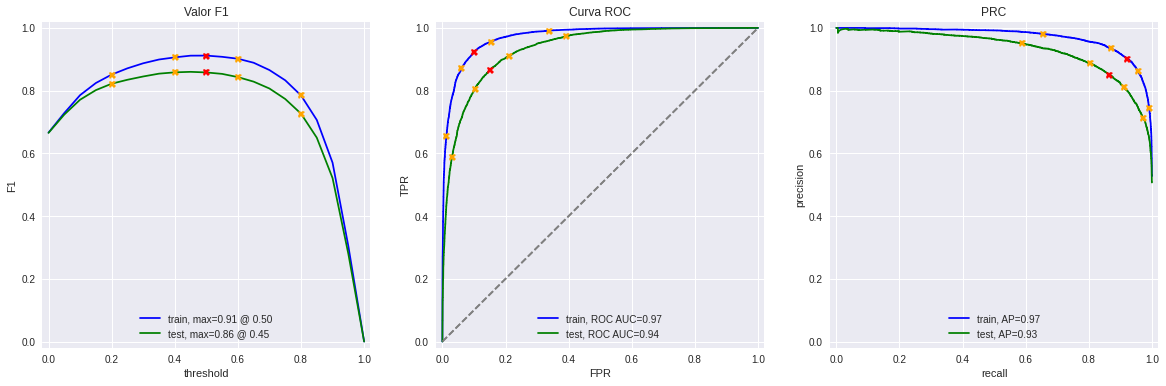

In [109]:
evaluate_model(lgbm_model, train_features_3, train_target, test_features_3, test_target)

1. El modelo tiene un rendimiento menor a los anteriores, pero no presenta señales claras de sobreajsute.

**Modelo 9 - BERT**

In [ ]:
#import torch
#import transformers

In [ ]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#    ids_list = []
#    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
       
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
#    if force_device is not None:
#        device = torch.device(force_device)
#    else:
#        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#    model.to(device)
#    if not disable_progress_bar:
#        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
#    embeddings = []

#    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
            
 #       with torch.no_grad():            
 #           model.eval()
#            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
 #   return np.concatenate(embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

# Mis reseñas <a name="reviews"></a>

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = ...# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

**Modelo 2**

In [740]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  simplemente no me gustó no es mi tipo de película
0.16:  bueno estaba aburrido y me quedé dormido a media película 
0.54:  estaba realmente fascinada con la película
0.11:  hasta los actores parecían muy viejos y desinteresados y les pagaron por estar en la película qué
0.31:  no esperaba que el relanzamiento fuera tan bueno los escritores realmente se preocuparon por el material original
0.47:  la película tuvo sus altibajos pero siento que en general es una película decente sí la volvería
0.04:  qué pésimo intento de comedia ni una sola broma tiene sentido todos actúan de forma irritante y ruidosa ni siquiera a los ni
0.82:  fue muy valiente el lanzamiento en netflix realmente aprecio poder seguir viendo episodio tras epi


**Modelo 3**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

**Modelo 4**

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

**Modelo 9**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

# Conclusiones <a name="conclusions"></a>

1. El modelo Dummy no tiene ninguna capcidad de predicción.

2. Los modelos de regresión logística, que utilizan NLTK y SPACY para la tokenización y lematización de textos, producen resultados similares (F1=0.87 en ambos casos). Esto cumple con el umbral requerido para el proyecto (F1=0.85).

3. Los modelos de regresión logística no presentan señales de sobreajuste, con diferencias pequeñas del valor de F1 entre los conjuntos de entrenamiento y prueba en el rango de 0.04 a 0.05.  

3. De acuerdo a las instrucciones del proyecto, no se utilizó el modelo BERT por cuanto no se cuenta con un GPU que acelere el proceso de modelado.

4. El modelo LGBM presenta un rendimiento menor en comparación a los modelos de regresión logística (F1=0.86). Sin embargo, se debe considerar que se utilizó el número mínimo de estimadores (100, número pre-estblecido por el modelo) para acortar el tiempo de entrenamiento. No obstante de esto, este modelo también cumple con el umbral establecido para este proyecto (F1=0.85). Este modelo tampoco presenta señales de sobreajuste.  

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código 
- [x]  Hay conclusiones 